# Graph results

Here you can find the scripts (along with the data) that generated the results of our Networking 2024 paper.

In [1]:
# Put all utilities here

import errno
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess

# Better resolution for plt.show()
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

SCRIPT_DIR = os.getcwd()

def get_cdf_data(sample):
    sorted_array = np.sort(sample)
    yvals = np.arange(len(sorted_array)) / float(len(sorted_array))
    if len(sorted_array) > 0:
        # Add a last point
        sorted_array = np.append(sorted_array, sorted_array[-1])
        yvals = np.append(yvals, 1.0)

    return sorted_array, yvals


def plot_cdf(plt, sample, **kwargs):
    sample_x, sample_y = get_cdf_data(sample)
    line, = plt.plot(sample_x, sample_y, **kwargs)
    return line


def run(*args, stdout=True, stderr=True, shell=True, env=None, timeout=None):
    kwargs = {}
    if not stdout:
        kwargs['stdout'] = subprocess.DEVNULL
    if not stderr:
        kwargs['stderr'] = subprocess.DEVNULL
    if env:
        kwargs['env'] = os.environ.copy()
        kwargs['env'].update(env)

    p = subprocess.Popen(args, universal_newlines=True, shell=shell, **kwargs)
    try:
        return p.wait(timeout=timeout)
    except:
        p.terminate()
        return 'timeout'


def run_data_extractor(
    input_dir,
    output_dir,
    metrics=["time", "acked-ranges", "stream-ranges", "bytes-sent"],
    with_name=None,
    data_extractor_path=os.path.join(SCRIPT_DIR, "data-extractor-rust/target/release/data-extractor"),
    ):
    # Create output_dir if it does not exist.
    try:
        os.makedirs(output_dir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise e

    for root, dirs, files in os.walk(input_dir):
        for f in files:
            if with_name is None or with_name in f:
                input_file = os.path.join(input_dir, f)
                for m in metrics:
                    output_file = os.path.join(output_dir, "{}-{}.json".format(os.path.splitext(f)[0], m))
                    run(" ".join([data_extractor_path, "-d", "-m", m, input_file, output_file]))


def count_retransmissions(range_list, count_bytes=False):
    retransmissions = 0
    seen = []
    # We cannot trust the input.
    range_list = [(int(x[0]), int(x[1])) for x in range_list]
    # End is non-included. This sorts by start.
    count = 0
    for start, length in sorted(range_list):
        count += length if count_bytes else 1
        end = start + length
        if seen:
            # Is it a retransmission?
            if seen[-1][0] <= start < seen[-1][1]:
                # We assume here that the whole frame is a retransmission.
                # This might not be true.
                retransmissions += length if count_bytes else 1

            # Now update the range
            if seen[-1][1] < end:
                seen[-1][1] = end

        else:
            # Initial data
            seen.append([start, end])

    if len(seen) != 1:
        print("Strange range!!! Len is {}".format(len(seen)))

    return retransmissions, count


LABELS_COLORS_LS = {
    'cubic-spns63': ("SPNS Cubic AR-64", '#d8b365', '-', 'X'),
    'cubic-spns32': ("SPNS Cubic", '#2b83ba', '-', 'o'),
    'cubic-spns32-h1024': ("SPNS Cubic AH-1024", '#abdda4', '-', 'D'),
    'cubic-spns63-h1024': ("SPNS Cubic AR-64 AH-1024", '#abdda4', '-', 'D'),
    'cubic-spns16': ("SPNS Cubic AR-17", '#abdda4', '-', 'D'),
    'cubic-spns8': ("SPNS Cubic AR-9", '#dfdf7f', '-', 'v'),
    'cubic-spns32-noaf': ("SPNS Cubic No AF", '#8c510a', '-', 'v'),
    'cubic-spns32-h128': ("SPNS Cubic AH-128", '#dfdf7f', '-', 'v'),
    'cubic-spns4': ("SPNS Cubic AR-5", '#fdae61', '-', 'X'),
    'bbr-spns63': ("SPNS BBR AR-64", '#d8b365', ':', 'X'),
    'bbr-spns32': ("SPNS BBR", '#2b83ba', ':', 'o'),
    'bbr-spns32-h1024': ("SPNS BBR AH-1024", '#abdda4', ':', 'D'),
    'bbr-spns63-h1024': ("SPNS BBR AR-64 AH-1024", '#abdda4', ':', 'D'),
    'bbr-spns16': ("SPNS BBR AR-17", '#abdda4', ':', 'D'),
    'bbr-spns8': ("SPNS BBR AR-9", '#dfdf7f', ':', 'v'),
    'bbr-spns32-noaf': ("SPNS BBR No AF", '#8c510a', ':', 'v'),
    'bbr-spns32-h128': ("SPNS BBR AH-128", '#dfdf7f', ':', 'v'),
    'bbr-spns4': ("SPNS BBR AR-5", '#fdae61', ':', 'X'),
    'cubic-mpns': ("MPNS Cubic", '#d7191c', '-', 's'),
    'bbr-mpns': ("MPNS BBR", '#d7191c', ':', 's'),
    'cubic-mpns-noaf': ("MPNS Cubic No AF", '#01665e', '-', 'D'),
    'bbr-mpns-noaf': ("MPNS BBR No AF", '#01665e', ':', 'D'),
    'pquic': ("MPNS PQUIC", 'purple', '-', '^'),
}


def plot_cdf_with_key(plt, data, **kwargs):
    if 'cdf_key' in kwargs:
        key = kwargs.pop('cdf_key')
        kwargs["label"], kwargs["color"], kwargs["ls"], kwargs["marker"] = LABELS_COLORS_LS[key]
        kwargs["markersize"] = 3
        kwargs["markevery"] = 10

    plot_cdf(plt, data, **kwargs)


def make_cdf_from_data(plt, raw_data, process_func, **kwargs):
    data = process_func(raw_data)
    plot_cdf_with_key(plt, data, **kwargs)

def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # also adapted from http://bkanuka.com/posts/native-latex-plots/

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    from math import sqrt
    import matplotlib

    assert(columns in [1,2])

    if fig_width is None:
        fig_width_pt = 506.295                             # Get this from LaTeX using \the\textwidth
        inches_per_pt = 1.0 / 72.27                      # Convert pt to inch
        scale = 3.39 / 6.9 if columns == 2 else 1
        fig_width = fig_width_pt * inches_per_pt * scale * 1.25 # width in inches
        # fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        # Modified version.
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        # golden_mean = (sqrt(4.5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean / 1.25 # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large {}: so will reduce to {} inches.".format(fig_height, MAX_HEIGHT_INCHES))
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              # 'text.latex.preamble': " ".join([r'\usepackage{libertine}', r'\usepackage[libertine]{newtxmath}', r'\usepackage[T1]{fontenc}', r'\usepackage{gensymb}']),
              # 'text.latex.preamble': " ".join([r'\usepackage{amsmath}']),
              'axes.labelsize': 9, # fontsize for x and y labels (was 10)
              'axes.titlesize': 9,
              'font.size': 9, # was 10
              'legend.fontsize': 9, # was 10
              'xtick.labelsize': 9,
              'ytick.labelsize': 9,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'pgf.texsystem': 'pdflatex',
              'grid.alpha': 0.25,
              'mathtext.default': 'regular', # Don't italize math text
              # 'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


quiche-quiche
quiche-quinn
quinn-quiche
quinn-quinn


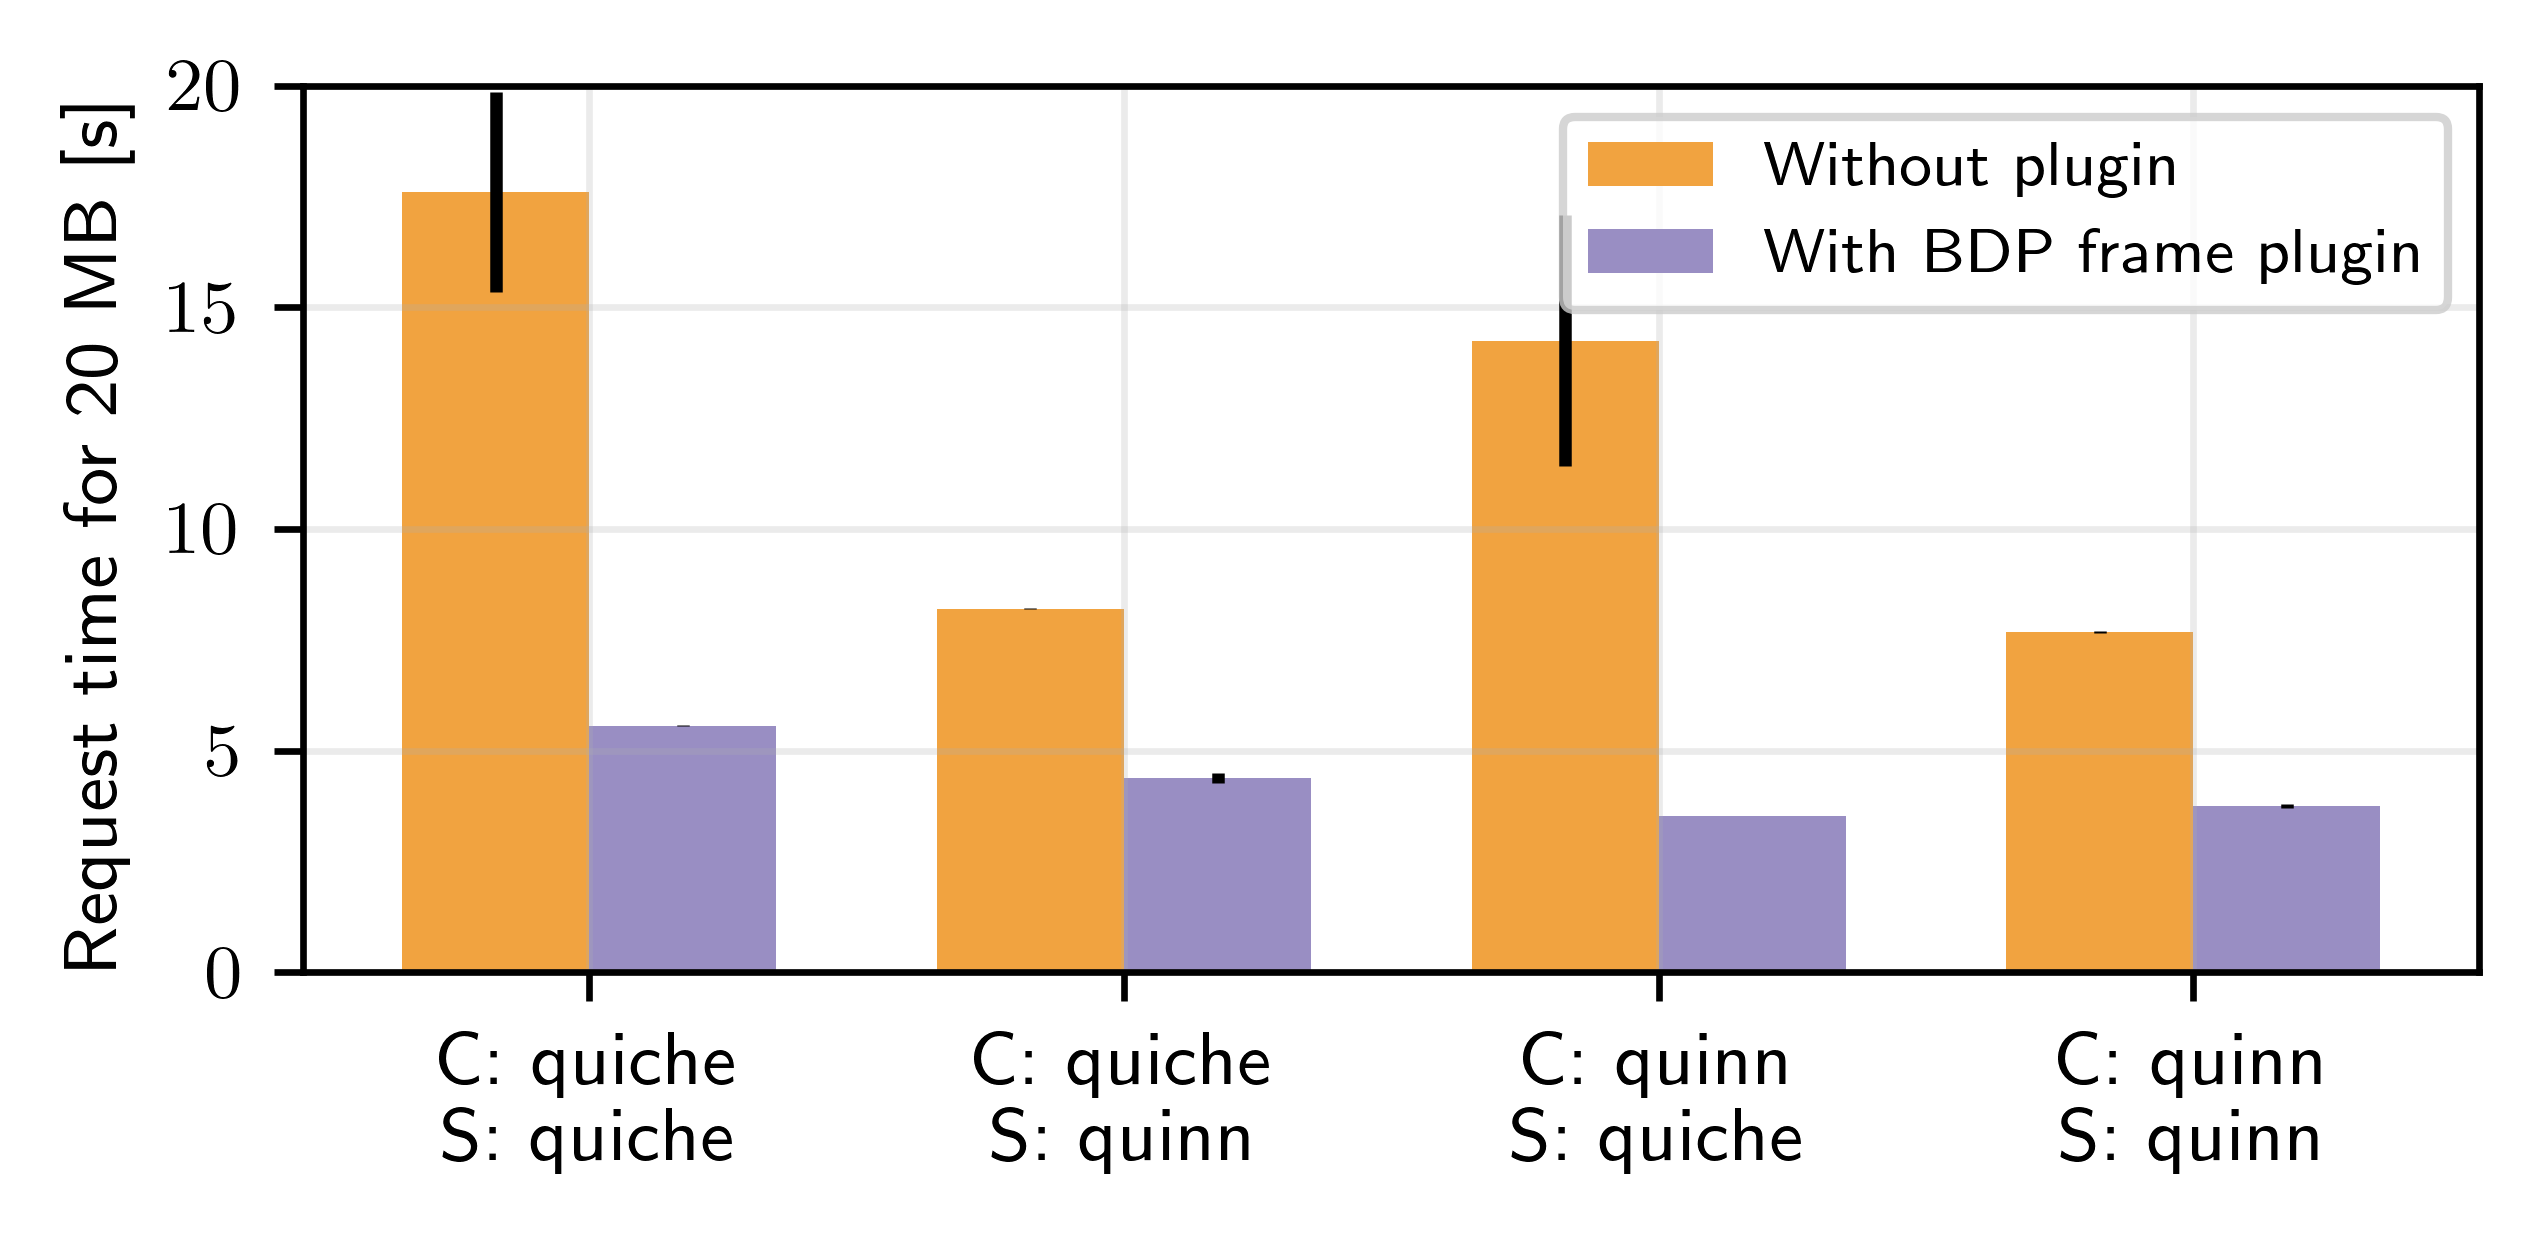

In [19]:
import sqlite3

conn = sqlite3.connect('networking24/bdp_frame_results_wnd_25000000.db')
c = conn.cursor()

configs = c.execute('SELECT DISTINCT xp_type, with_plugin FROM results').fetchall()

N = len(configs) // 2

without_plugin_data_med = []
without_plugin_data_std = []
gen = ((xp, wp) for (xp, wp) in configs if wp == 0)
for (xp, wp) in gen:
    print(xp)
    raw_data = c.execute('SELECT transfer_time FROM results WHERE xp_type = ? AND with_plugin = ?', (xp, wp)).fetchall()
    float_data = [float(rd[0].split('s')[0]) for rd in raw_data]
    without_plugin_data_med.append(np.median(float_data))
    without_plugin_data_std.append(np.std(float_data))

fig, ax = plt.subplots()
\
ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, without_plugin_data_med, width, bottom=0, yerr=without_plugin_data_std, color="#f1a340")

with_plugin_data_med = []
with_plugin_data_std = []
gen = ((xp, wp) for (xp, wp) in configs if wp == 1)
for (xp, wp) in gen:
    raw_data = c.execute('SELECT transfer_time FROM results WHERE xp_type = ? AND with_plugin = ?', (xp, wp)).fetchall()
    float_data = [float(rd[0].split('s')[0]) for rd in raw_data]
    with_plugin_data_med.append(np.median(float_data))
    with_plugin_data_std.append(np.std(float_data))

p2 = ax.bar(ind + width, with_plugin_data_med, width, bottom=0, yerr=with_plugin_data_std, color="#998ec3")

# ax.set_title('Transfer time with BDP frame')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('C: quiche\nS: quiche', 'C: quiche\nS: quinn', 'C: quinn\nS: quiche', 'C: quinn\nS: quinn'))

ax.legend((p1[0], p2[0]), ('Without plugin', 'With BDP frame plugin'), fontsize=7.5)
ax.grid()

ax.set_ylim(ymax=20)

ax.set_ylabel("Request time for 20 MB [s]")

latexify()
fig.tight_layout()

# fig.savefig('bdp_frame_wnd_25000000.pdf')

In [6]:
import dpkt
from dpkt.utils import inet_to_str

def extract_data_from_pcap(pcap, from_start=False, src=None):
    first_ts = None
    last_ts = None
    ts_space = []
    pkt_size = []
    # For each packet in the pcap process the contents
    for timestamp, buf in pcap:
        # Unpack the Ethernet frame (mac src/dst, ethertype)
        eth = dpkt.sll2.SLL2(buf)

        # Make sure the Ethernet data contains an IP packet
        if not isinstance(eth.data, dpkt.ip.IP):
            # print('Non IP Packet type not supported %s\n' % eth.data.__class__.__name__)
            continue

        # Now grab the data within the Ethernet frame (the IP packet)
        ip = eth.data


        if src and inet_to_str(ip.src) != src:
            continue
        
        # Check for TCP in the transport layer
        if isinstance(ip.data, dpkt.udp.UDP):

            if not first_ts:
                first_ts = timestamp

            ts = timestamp - first_ts

            # Set the TCP data
            udp = ip.data

            pkt_size.append(len(udp.data))

            if last_ts:
                if from_start:
                    ts_space.append(ts)
                else:
                    ts_space.append(ts - last_ts)

            last_ts = ts

    return (ts_space, pkt_size)

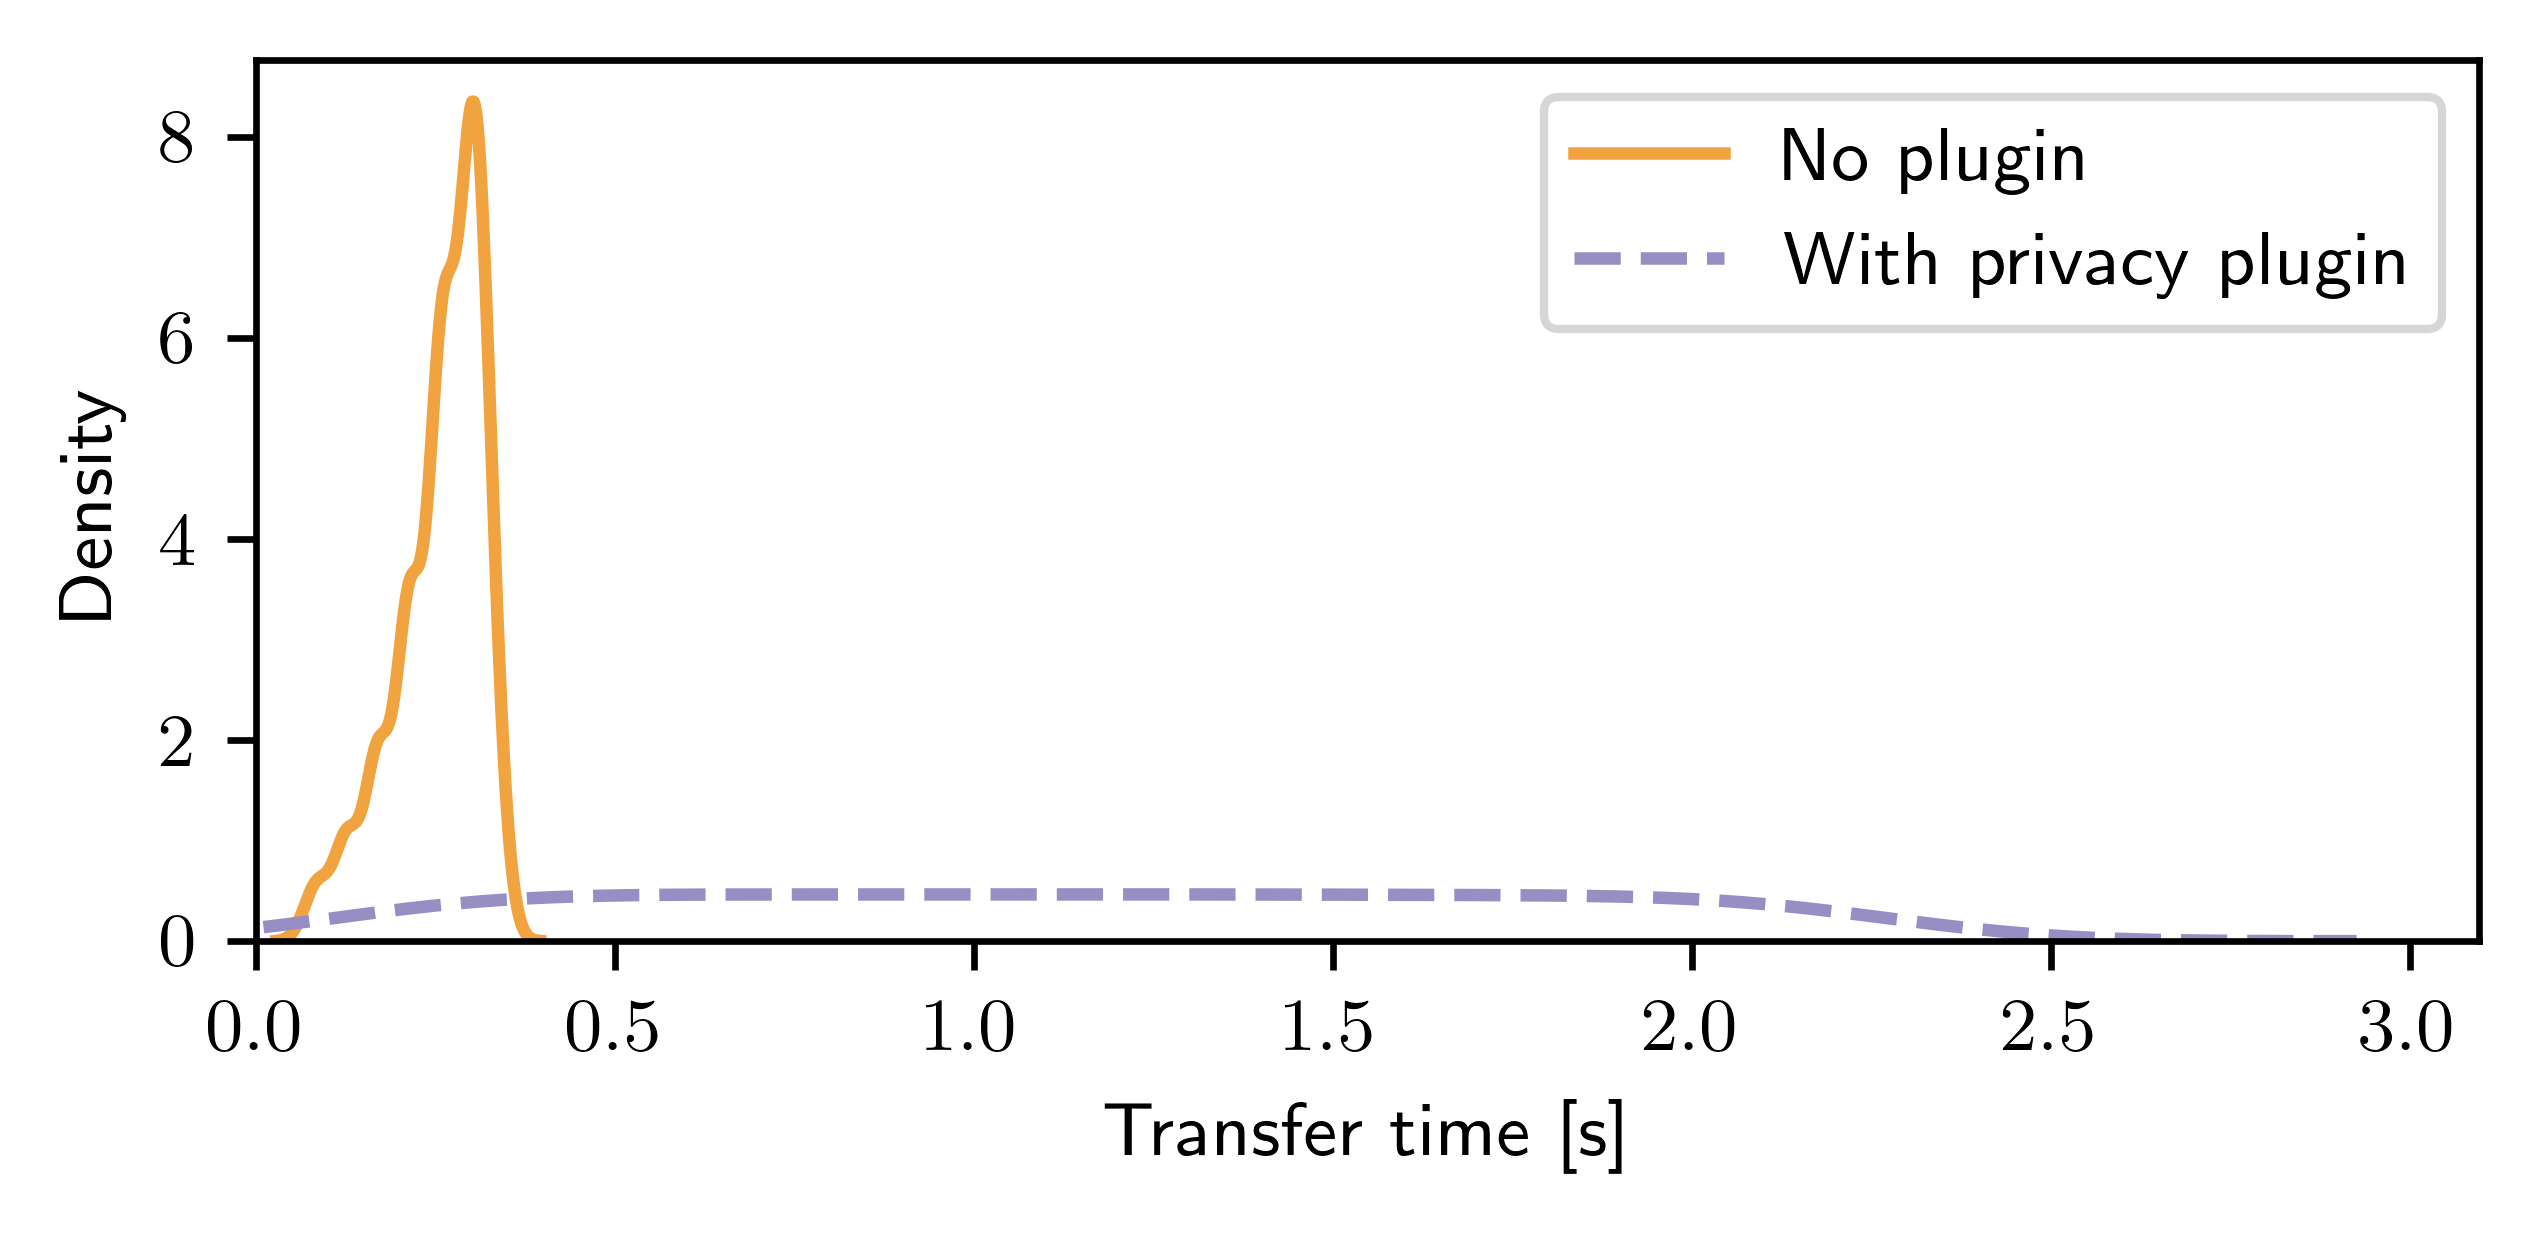

In [14]:
import sqlite3

conn = sqlite3.connect('networking24/Privacy_quinn_quiche/privacy_results.db')
c = conn.cursor()

configs = c.execute('SELECT DISTINCT with_plugin FROM results').fetchall()
ts_space = {}
pkt_size = {}
for conf in configs:
    ts_space[conf[0]] = []
    pkt_size[conf[0]] = []

configs = c.execute('SELECT with_plugin FROM results').fetchall()

for (i, conf) in enumerate(configs, start=1):
    fname = "networking24/Privacy_quinn_quiche/client-{}.pcap".format(i)
    with open(fname, 'rb') as f:
            pcap = dpkt.pcap.Reader(f)
            (loc_ts_space, loc_pkt_size) = extract_data_from_pcap(pcap, src="10.1.0.1", from_start=True)
            ts_space[conf[0]] += loc_ts_space
            pkt_size[conf[0]] += loc_pkt_size

def plot_pdf(plt, sample, **kwargs):
    import seaborn as sns
    sns.kdeplot(sample, bw_adjust=2, **kwargs)

LS = {0: "-", 1: "--"}
LABELS = {0: "No plugin", 1: "With privacy plugin"}
COLORS = {0: "#f1a340", 1: "#998ec3"}
for (k, v) in ts_space.items():
    plot_pdf(plt, v, label=LABELS[k], ls=LS[k], color=COLORS[k])

plt.legend()
plt.xlim(xmin=0)
plt.xlabel("Transfer time [s]")
plt.tight_layout()
latexify()
# plt.savefig("privacy_quinn_quiche_server_ts.pdf")

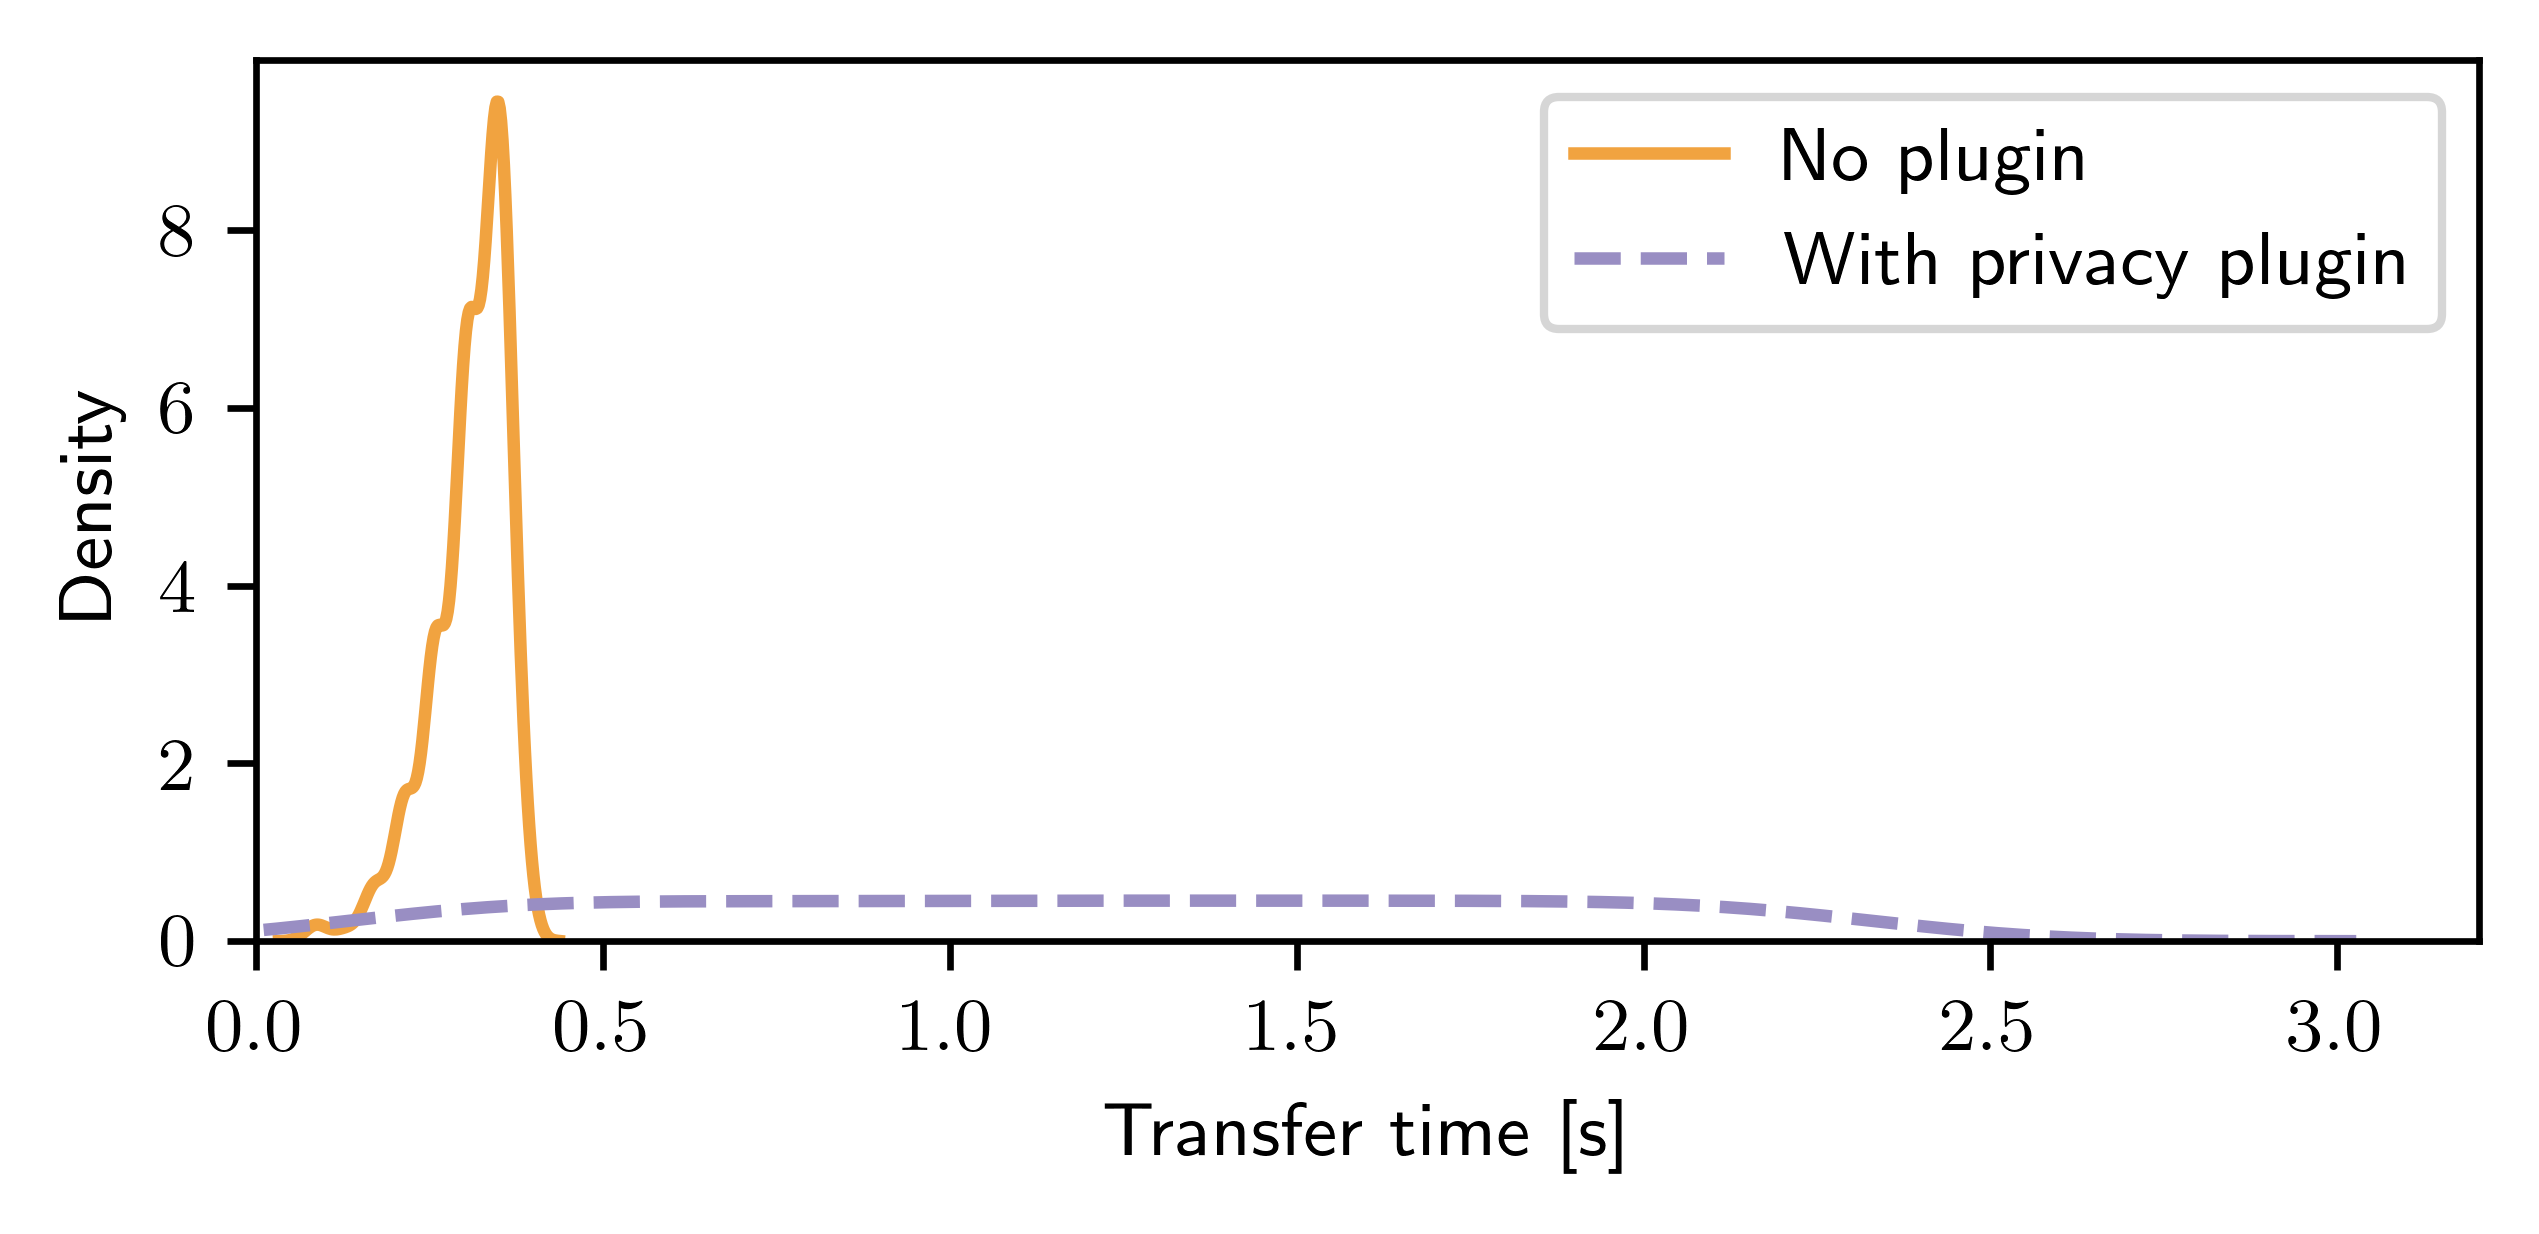

In [15]:
import sqlite3

conn = sqlite3.connect('networking24/Privacy_quinn_quiche/privacy_results.db')
c = conn.cursor()

configs = c.execute('SELECT DISTINCT with_plugin FROM results').fetchall()
ts_space = {}
pkt_size = {}
for conf in configs:
    ts_space[conf[0]] = []
    pkt_size[conf[0]] = []

configs = c.execute('SELECT with_plugin FROM results').fetchall()

for (i, conf) in enumerate(configs, start=1):
    fname = "networking24/Privacy_quinn_quiche/server-{}.pcap".format(i)
    with open(fname, 'rb') as f:
            pcap = dpkt.pcap.Reader(f)
            (loc_ts_space, loc_pkt_size) = extract_data_from_pcap(pcap, src="10.0.0.1", from_start=True)
            ts_space[conf[0]] += loc_ts_space
            pkt_size[conf[0]] += loc_pkt_size

def plot_pdf(plt, sample, **kwargs):
    import seaborn as sns
    sns.kdeplot(sample, bw_adjust=2, **kwargs)

LS = {0: "-", 1: "--"}
LABELS = {0: "No plugin", 1: "With privacy plugin"}
COLORS = {0: "#f1a340", 1: "#998ec3"}
for (k, v) in ts_space.items():
    plot_pdf(plt, v, label=LABELS[k], ls=LS[k], color=COLORS[k])
    # plot_cdf(plt, v, label=str(k), ls=LS[k])

plt.legend()
plt.xlim(xmin=0)
plt.xlabel("Transfer time [s]")
plt.tight_layout()
latexify()
# plt.savefig("privacy_quinn_quiche_client_ts.pdf")

(0.0, 1.0)

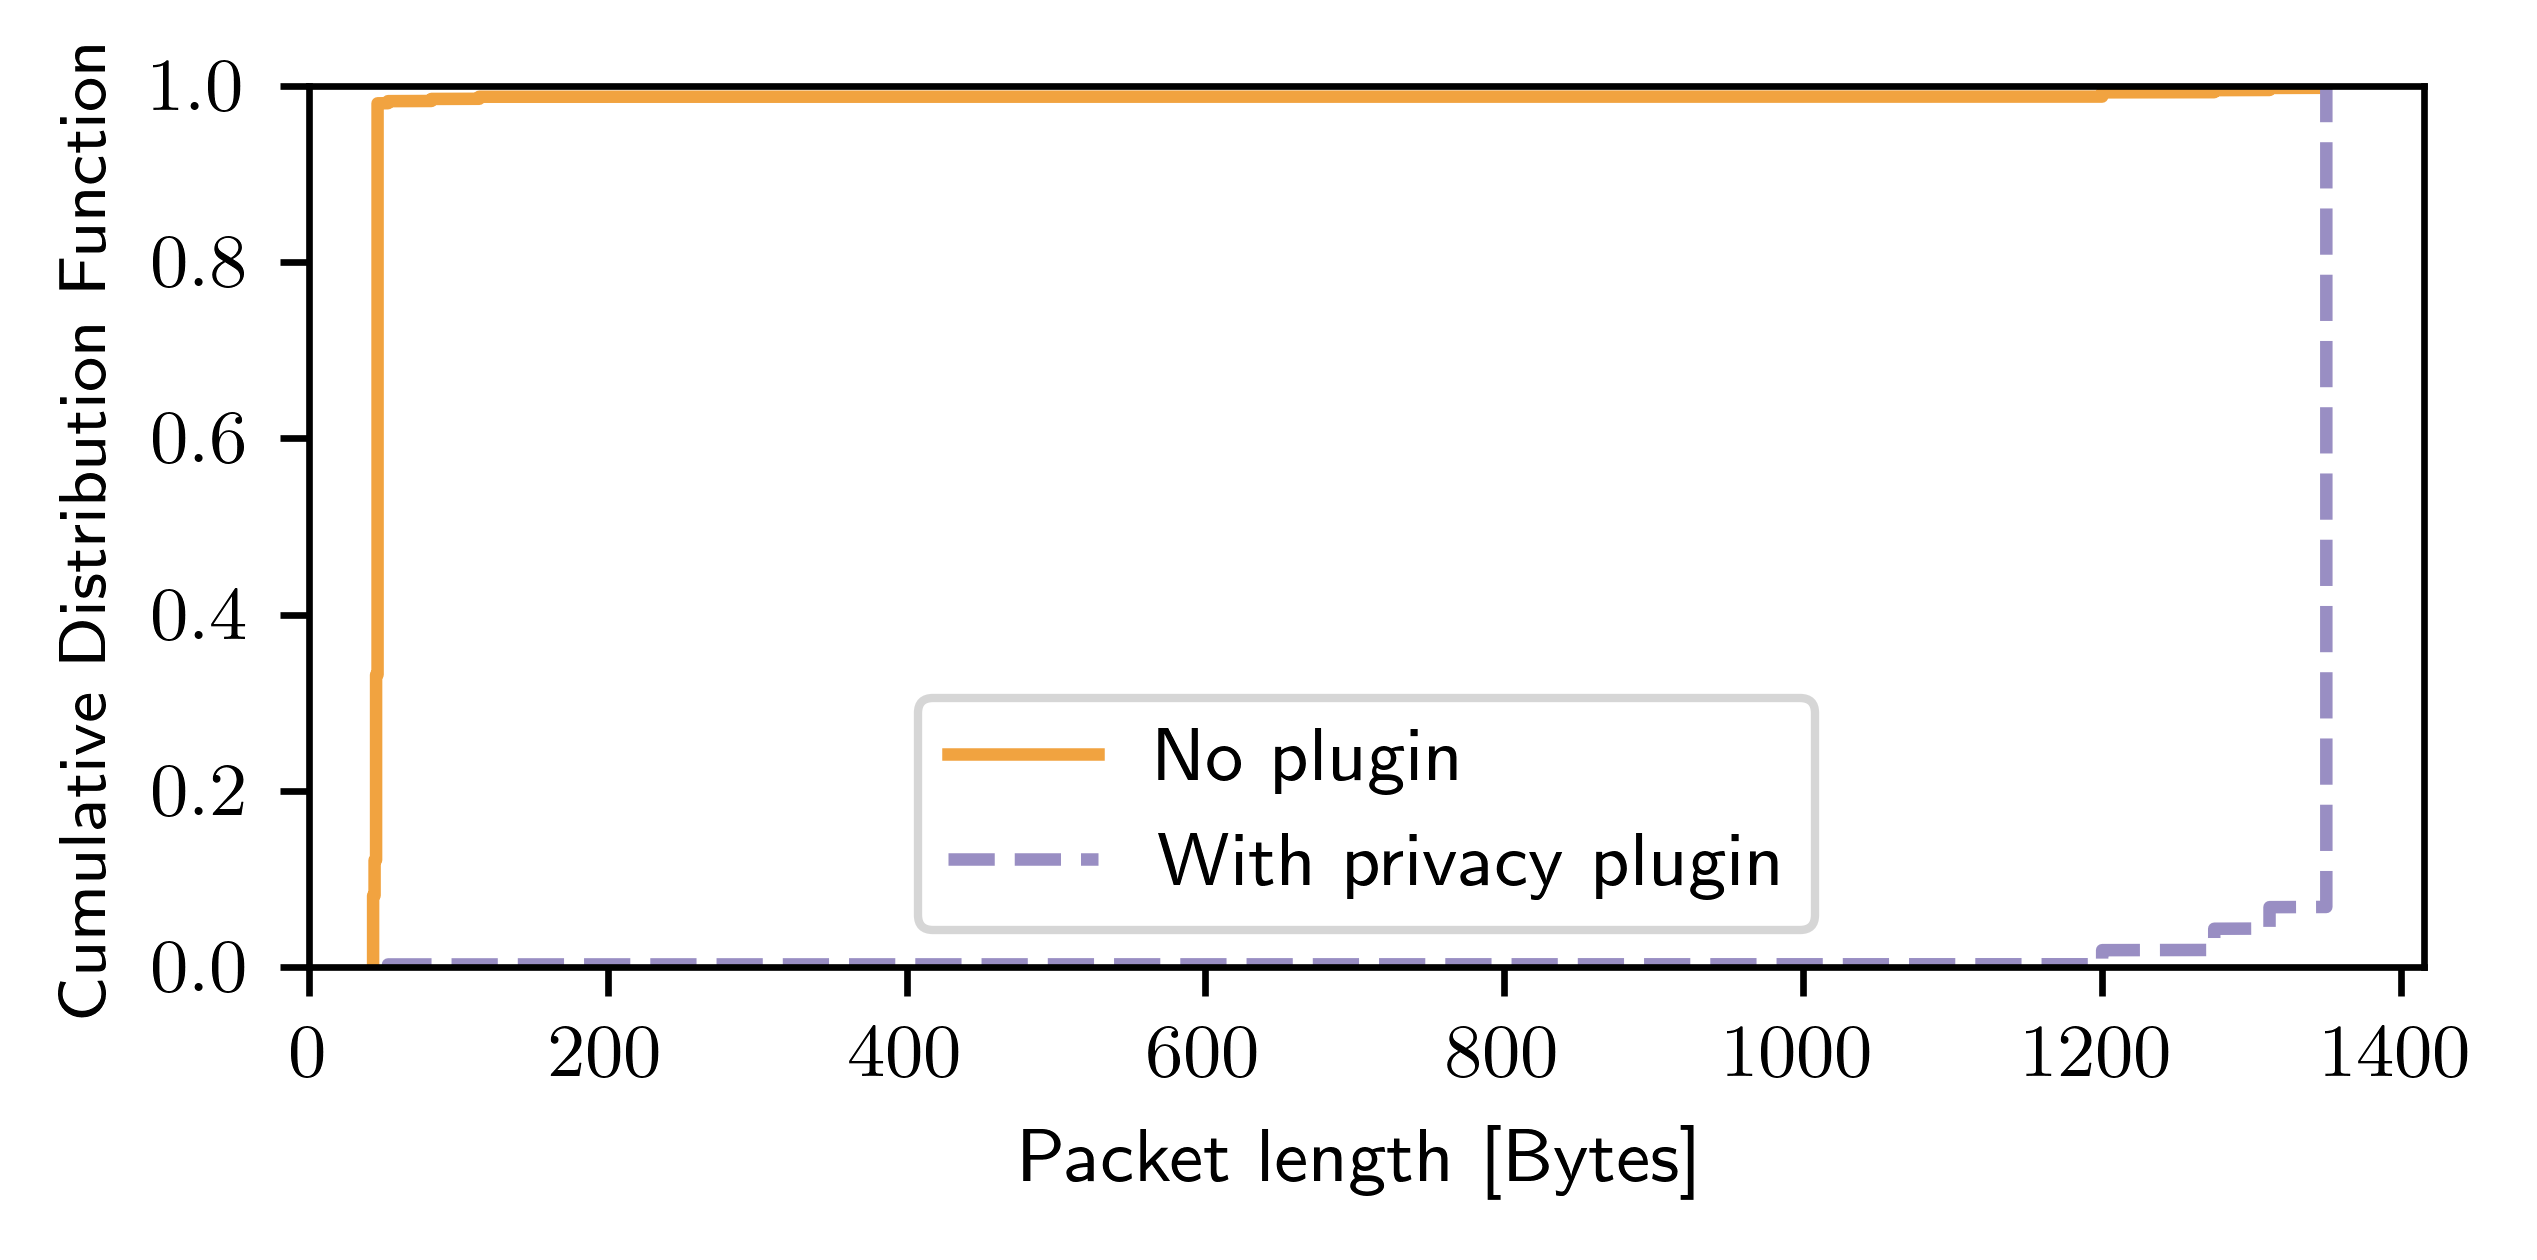

In [16]:
import sqlite3

conn = sqlite3.connect('networking24/Privacy_quinn_quiche/privacy_results.db')
c = conn.cursor()

configs = c.execute('SELECT DISTINCT with_plugin FROM results').fetchall()
ts_space = {}
pkt_size = {}
for conf in configs:
    ts_space[conf[0]] = []
    pkt_size[conf[0]] = []

configs = c.execute('SELECT with_plugin FROM results').fetchall()

for (i, conf) in enumerate(configs, start=1):
    fname = "networking24/Privacy_quinn_quiche/server-{}.pcap".format(i)
    with open(fname, 'rb') as f:
            pcap = dpkt.pcap.Reader(f)
            (loc_ts_space, loc_pkt_size) = extract_data_from_pcap(pcap, src="10.0.0.1")
            ts_space[conf[0]] += loc_ts_space
            pkt_size[conf[0]] += loc_pkt_size

LS = {0: "-", 1: "--"}
LABELS = {0: "No plugin", 1: "With privacy plugin"}
COLORS = {0: "#f1a340", 1: "#998ec3"}
for (k, v) in pkt_size.items():
    plot_cdf(plt, v, label=LABELS[k], ls=LS[k], color=COLORS[k])

plt.legend()
plt.ylabel("Cumulative Distribution Function", fontsize=8)
plt.xlabel("Packet length [Bytes]")
plt.tight_layout()
latexify()
plt.xlim(xmin=0)
plt.ylim(ymin=0, ymax=1)
# plt.savefig("privacy_quinn_quiche_client_size.pdf")

(0.0, 1.0)

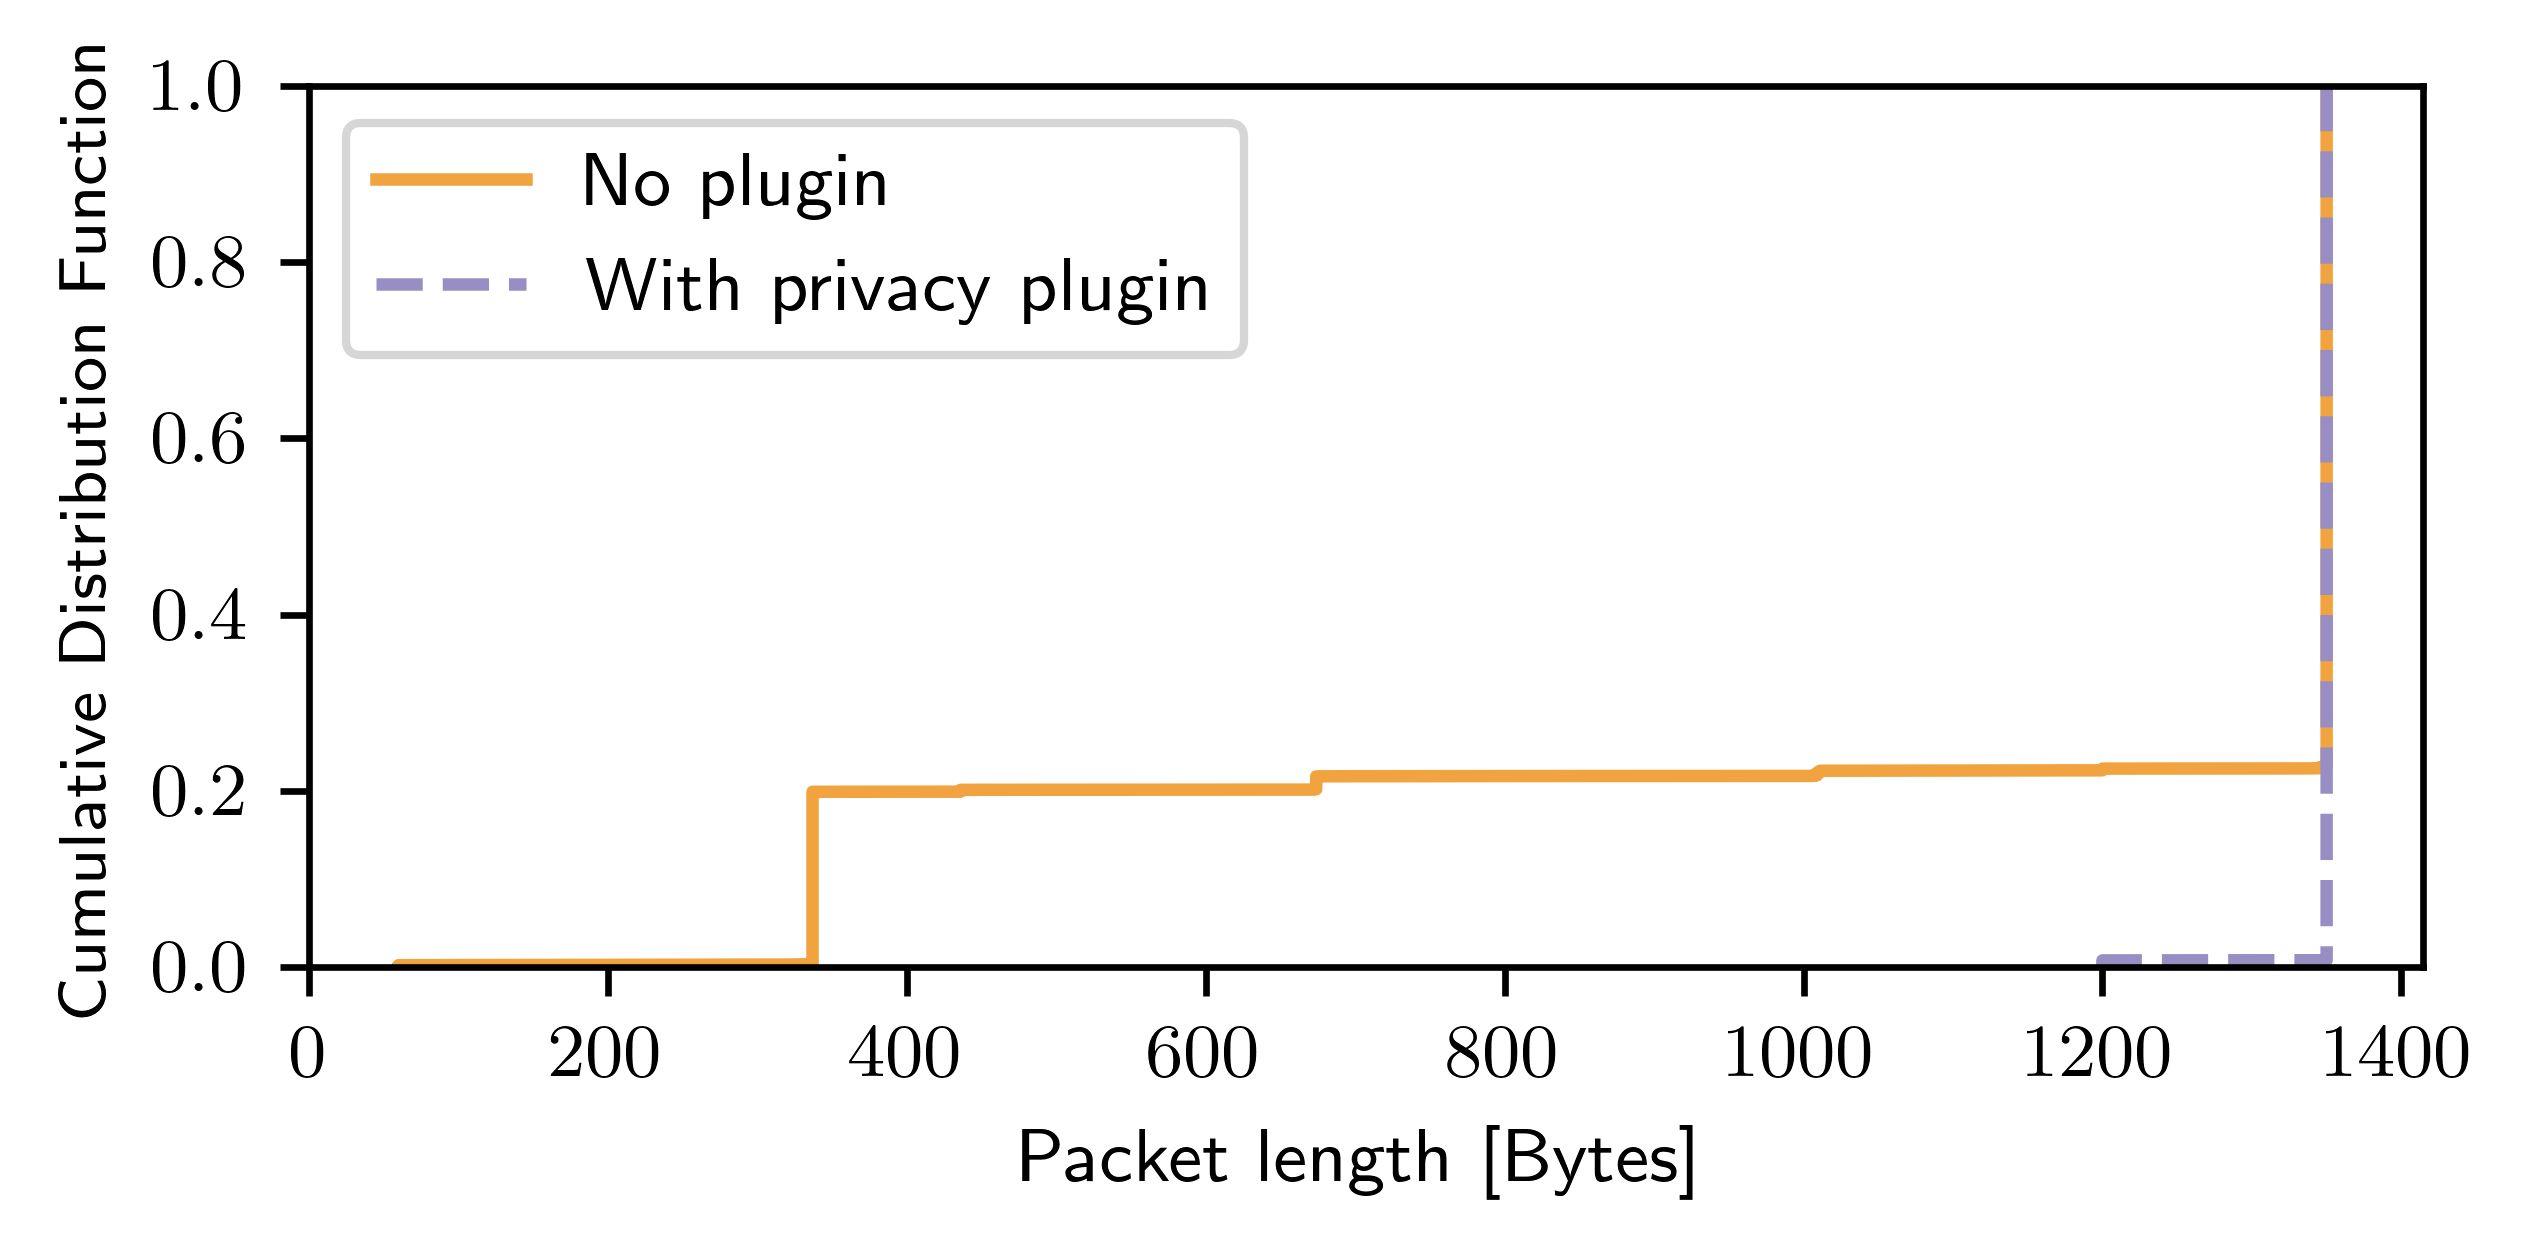

In [17]:
import sqlite3

conn = sqlite3.connect('networking24/Privacy_quinn_quiche/privacy_results.db')
c = conn.cursor()

configs = c.execute('SELECT DISTINCT with_plugin FROM results').fetchall()
ts_space = {}
pkt_size = {}
for conf in configs:
    ts_space[conf[0]] = []
    pkt_size[conf[0]] = []

configs = c.execute('SELECT with_plugin FROM results').fetchall()

for (i, conf) in enumerate(configs, start=1):
    fname = "networking24/Privacy_quinn_quiche/client-{}.pcap".format(i)
    with open(fname, 'rb') as f:
            pcap = dpkt.pcap.Reader(f)
            (loc_ts_space, loc_pkt_size) = extract_data_from_pcap(pcap, src="10.1.0.1")
            ts_space[conf[0]] += loc_ts_space
            pkt_size[conf[0]] += loc_pkt_size

LS = {0: "-", 1: "--"}
LABELS = {0: "No plugin", 1: "With privacy plugin"}
COLORS = {0: "#f1a340", 1: "#998ec3"}
for (k, v) in pkt_size.items():
    plot_cdf(plt, v, label=LABELS[k], ls=LS[k], color=COLORS[k])

plt.legend()
plt.ylabel("Cumulative Distribution Function", fontsize=8)
plt.xlabel("Packet length [Bytes]")
plt.tight_layout()
latexify()
plt.xlim(xmin=0)
plt.ylim(ymin=0, ymax=1)
# plt.savefig("privacy_quinn_quiche_server_size.pdf")

(0.0, 1415.9)

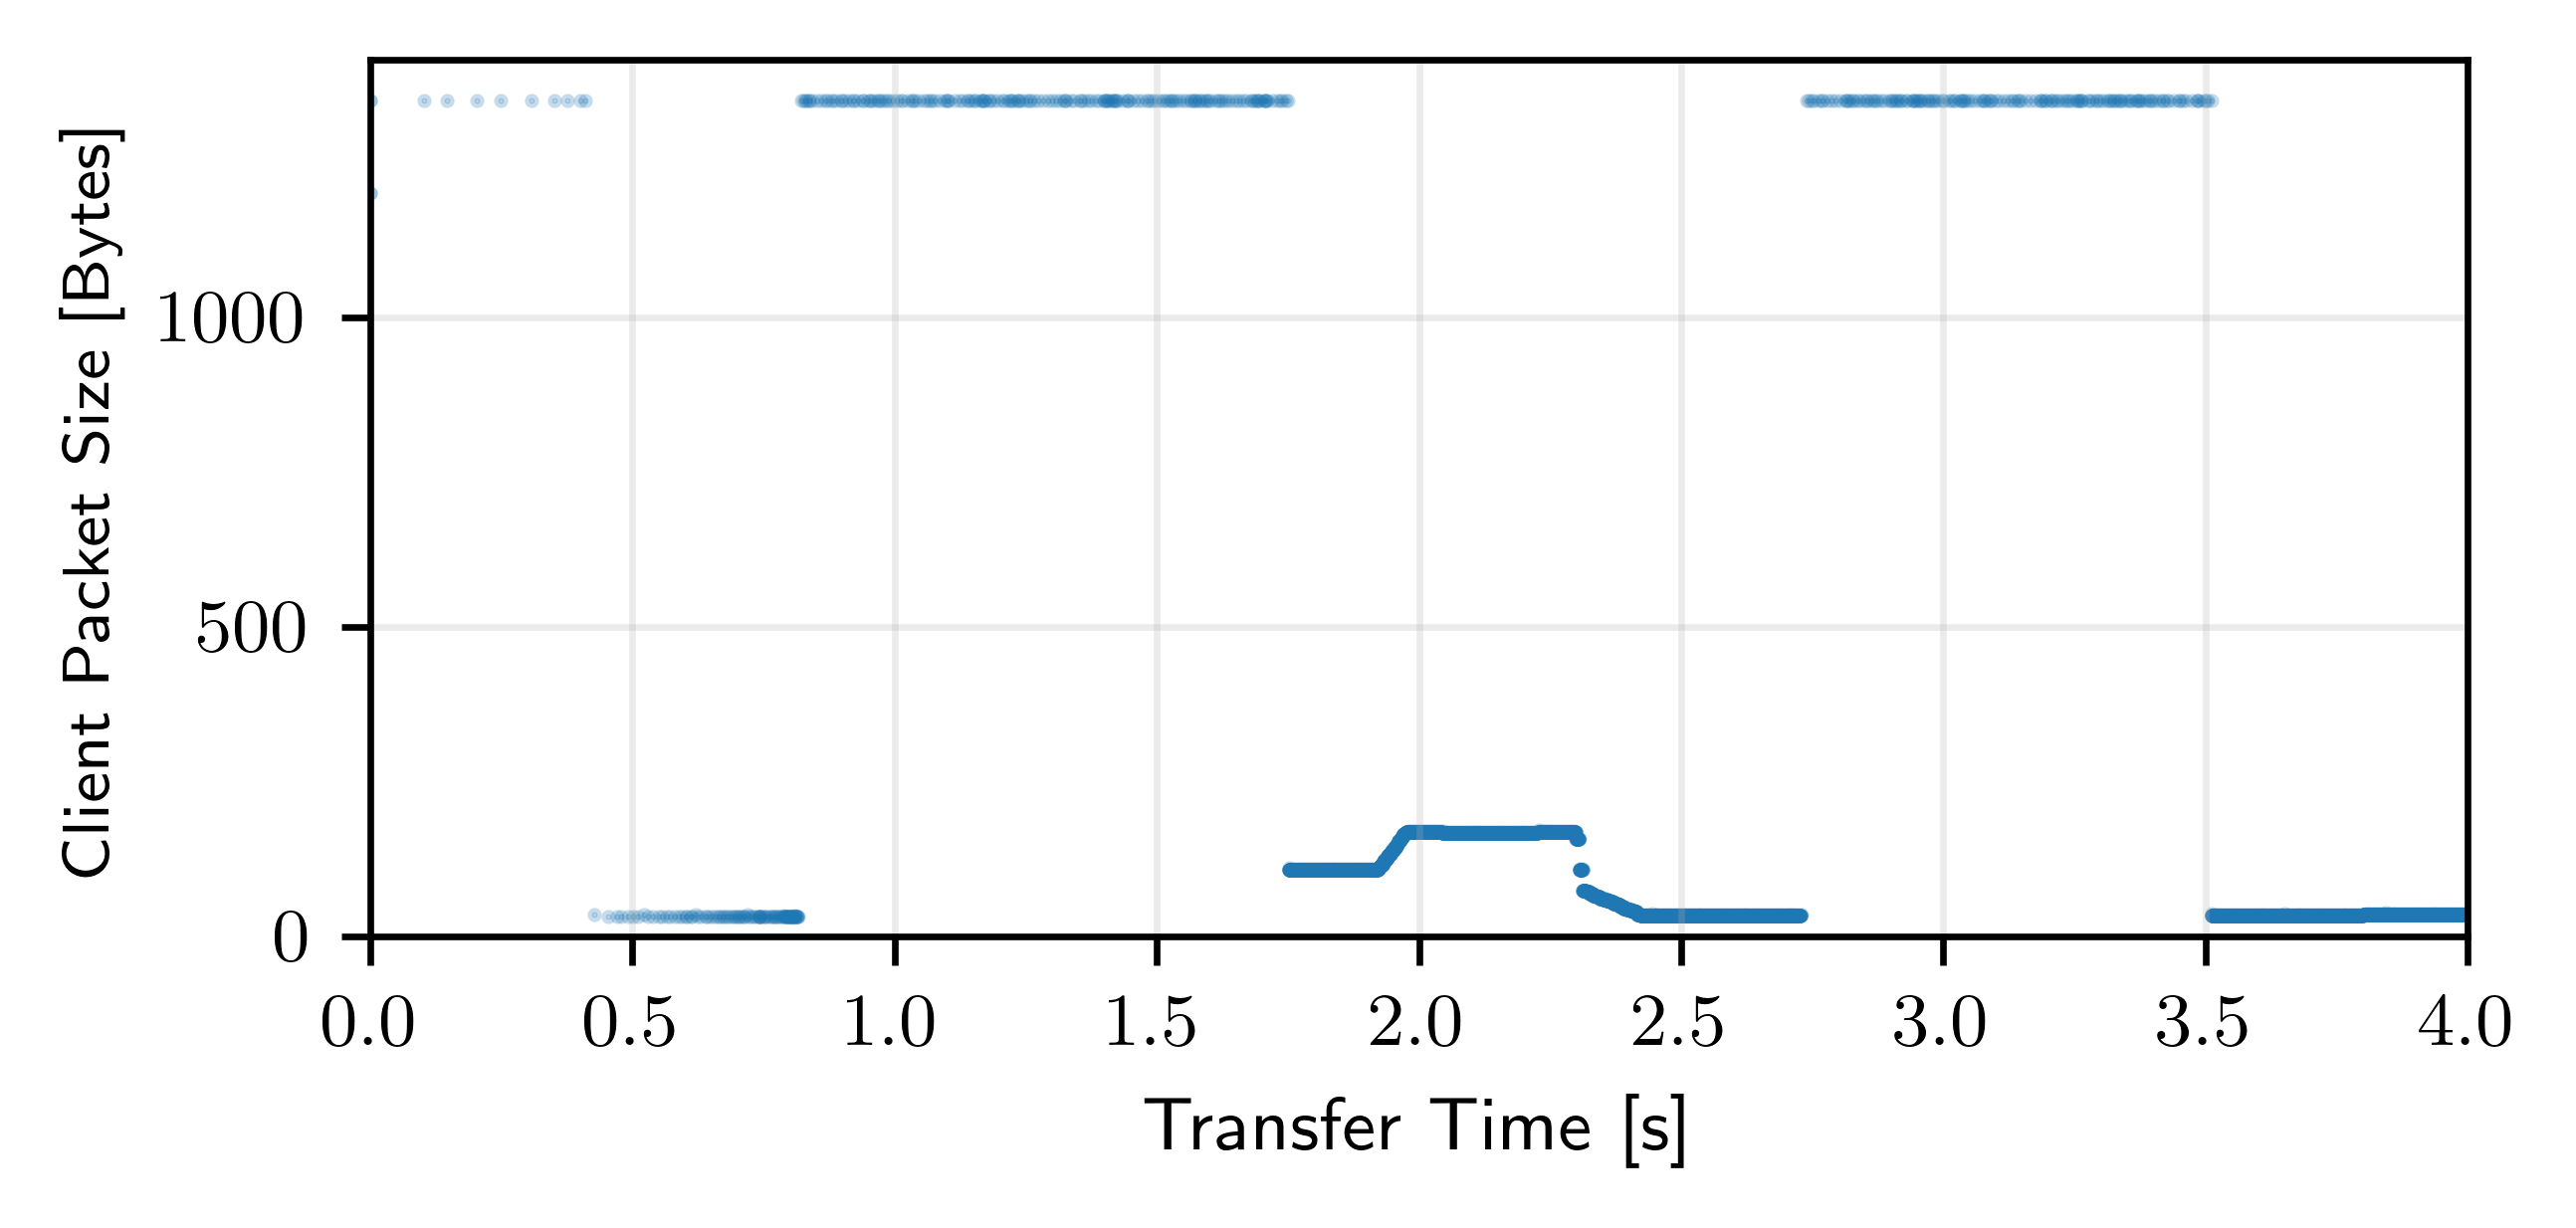

In [18]:
fname = "networking24/C5/server.pcap"
with open(fname, 'rb') as f:
    pcap = dpkt.pcap.Reader(f)
    (loc_ts_space, loc_pkt_size) = extract_data_from_pcap(pcap, from_start=True, src="10.0.0.1")

loc_ts_space = [loc_ts_space[0]] + loc_ts_space + [loc_ts_space[-1]]
start = loc_ts_space[0]
loc_ts_space = [l - start for l in loc_ts_space]

plt.scatter(loc_ts_space, loc_pkt_size, s=0.5, alpha=.25)
plt.xlim(xmin=0)

plt.ylabel("Client Packet Size [Bytes]", fontsize=8)
plt.xlabel("Transfer Time [s]")
plt.tight_layout()
latexify()
plt.grid()
plt.xlim(xmin=loc_ts_space[0], xmax=4)
plt.ylim(ymin=0)
# plt.savefig("combined.pdf")